In [1]:
# import modules
import numpy as np
import random
import math

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


## 1. Two moons with an invertible neural network

In [13]:
# construct a RealNVP
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks # number of coupling layers

        self.D_tilde = self.input_size // 2 # dimension of the first half of the input
        # construct the network: two hidden layers with relu activation and one output layer
        self.nets = nn.ModuleList(nn.Sequential(
            nn.Linear(self.D_tilde, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.D_tilde * 2) # output layer s and t
        ) for _ in range(self.blocks) )
        
        # construct the orthogonal matrix
        self.shuffle = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        self.shuffle_inverse = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        # initialize the orthogonal matrix using a random orthogonal matrix
        for i in range(self.blocks-1):
            # generate a random orthogonal matrix
            Q, _ = torch.linalg.qr(torch.randn(self.input_size, self.input_size))
            # set the parameters of the linear layer to the random orthogonal matrix
            self.shuffle[i].weight.data = Q
            self.shuffle[i].bias.data = torch.zeros(self.input_size)
            self.shuffle_inverse[i].weight.data = Q.t()
            self.shuffle_inverse[i].bias.data = torch.zeros(self.input_size)
        # freeze the orthogonal matrix
        for param in self.shuffle.parameters():
            param.requires_grad = False
        for param in self.shuffle_inverse.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        # for the second half of the dimensions rely on the first half
        log_det_J = 0
        for i in range(self.blocks):
            # the first half of the dimensions are not changed
            x_1 = x[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[i](x_1), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            x_2 = x[:, self.D_tilde:] * torch.exp(torch.tanh(s)) + t
            # combine the first and second half of the dimensions
            x = torch.cat([x_1, x_2], dim=1)
            # update the log determinant of the Jacobian
            log_det_J += torch.sum(torch.log(1 - torch.tanh(s)**2) + torch.tanh(s), dim=1)
            if i != self.blocks-1:
                # change the dimensions by the random orthogonormal matrix
                x = self.shuffle[i](x)
        return x, log_det_J
    
    def inverse(self, z):
        # for the second half of the dimensions rely on the first half
        for i in range(self.blocks):
            if i != 0:
                # change the dimensions by the inverse of the random orthogonormal matrix
                z = self.shuffle_inverse[self.blocks-1-i](z)
            # the first half of the dimensions are not changed
            z_1 = z[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[self.blocks-1-i](z_1), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            z_2 = (z[:, self.D_tilde:] - t) * torch.exp(-torch.tanh(s))
            # combine the first and second half of the dimensions
            z = torch.cat([z_1, z_2], dim=1)
        return z
    
    def sample(self, num_samples):
        # sample from a standard normal distribution
        z = torch.randn(num_samples, self.input_size)
        # apply the inverse of the flow
        x = self.inverse(z)
        return x

In [14]:
# construct a training function
def train_inn(inn, data, batch_size, epochs, visualize=False):
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset = data, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.float()
            z, log_det_J = inn(batch)
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) - torch.mean(log_det_J)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
            
            

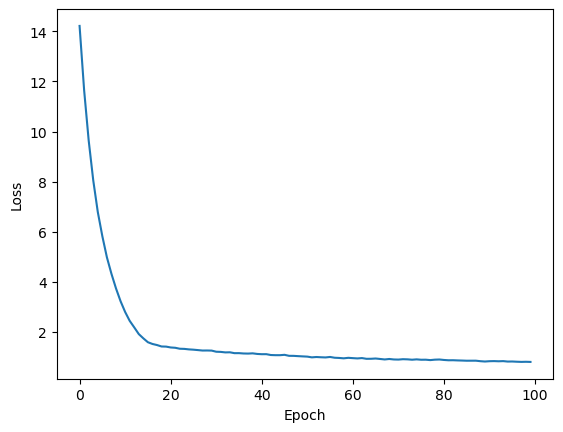

In [21]:
# create a small dataset
n_samples = 1000
n_epochs = 100
blocks = 4
hidden_size = 8
batch_size = 150
input_size = 2

X, _ = make_moons(n_samples=n_samples, noise=.1)

inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=True)

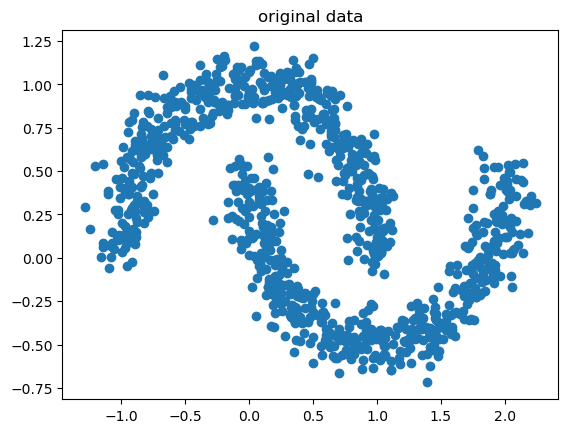

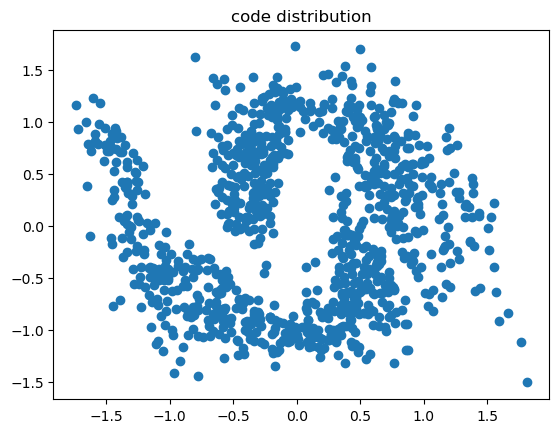

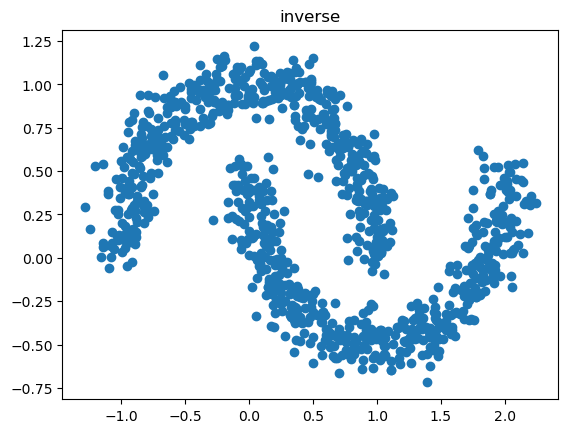

In [16]:
# visualize the original data
X = torch.from_numpy(X).float()
plt.scatter(X[:, 0], X[:, 1])
plt.title('original data')
plt.show()

# visualize the results
z, _ = inn(X)
z = z.detach().numpy()
plt.scatter(z[:, 0], z[:, 1])
plt.title('code distribution')
plt.show()

# visualize the inverse
z = torch.from_numpy(z).float()
X_inv = inn.inverse(z)
X_inv = X_inv.detach().numpy()
plt.scatter(X_inv[:, 0], X_inv[:, 1])
plt.title('inverse')
plt.show()

Comment: The original data points are the same as the inverse data, and the reconstruction errors are 0, incidating that our code works well.

Then we will check the effect of hyperparameters and find the optimal hyperparameter combination.

Training with hidden size 2
Training with hidden size 4
Training with hidden size 8
Training with hidden size 16
Training with hidden size 32
Training with hidden size 64


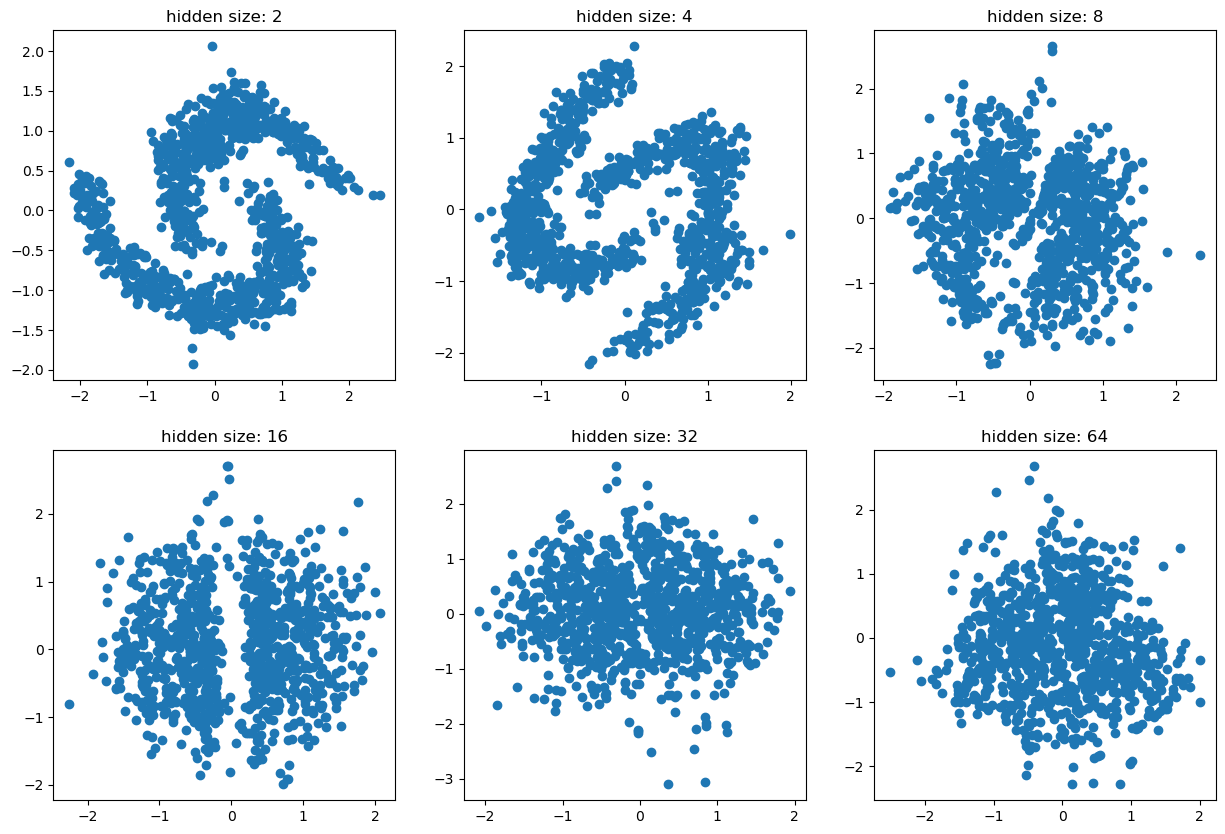

In [25]:
# Check the effect of varying the number of hidden units
n_samples = 1000
n_epochs = 100
blocks = 8
hidden_sizes = [2, 4, 8, 16, 32, 64]

X, _ = make_moons(n_samples=n_samples, noise=.1)
X = torch.from_numpy(X).float()

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, hidden_size in enumerate(hidden_sizes):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with hidden size {hidden_size}')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('hidden size: {}'.format(hidden_size))

Training with 2 blocks
Training with 4 blocks
Training with 6 blocks
Training with 8 blocks
Training with 10 blocks
Training with 12 blocks


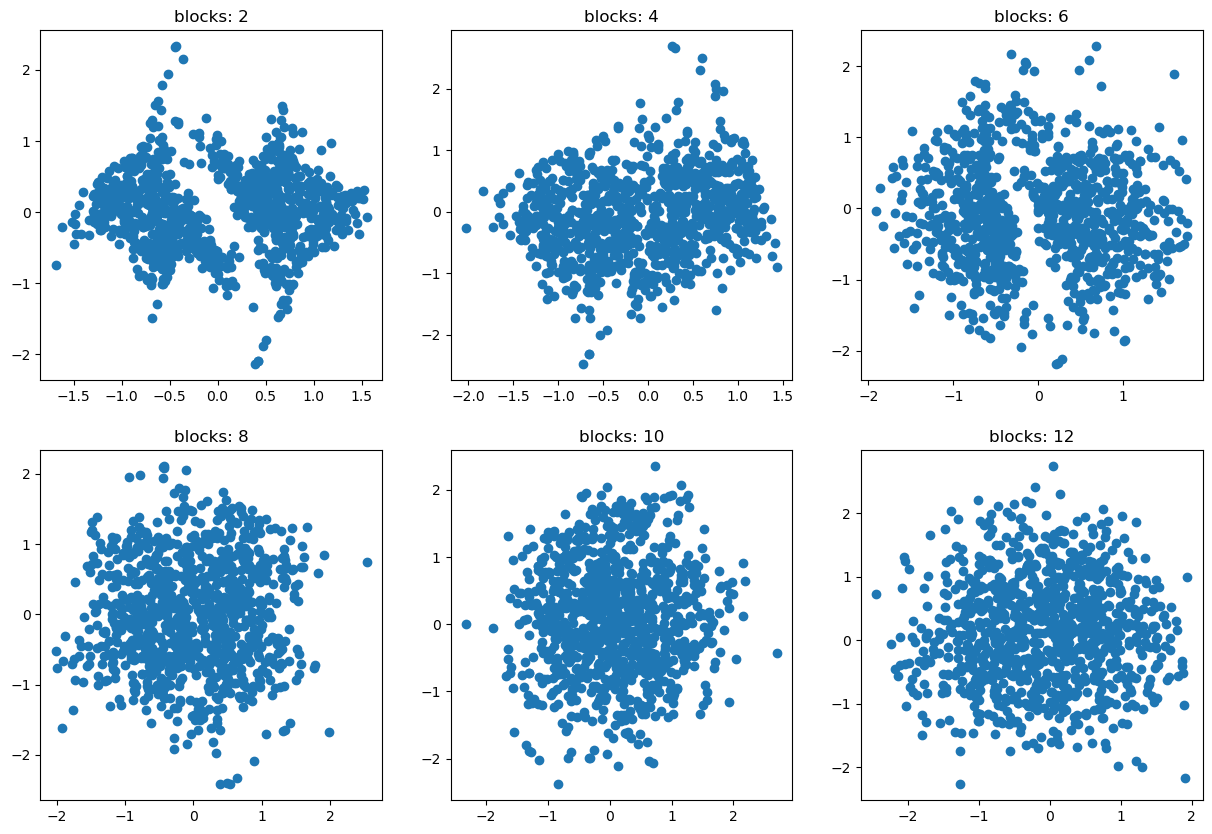

In [26]:
# Check the effect of varying the number of blocks
n_samples = 1000
n_epochs = 100
blocks = [2, 4, 6, 8, 10, 12]
hidden_size = 64

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, block in enumerate(blocks):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=block)
    print(f'Training with {block} blocks')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('blocks: {}'.format(block))

Training with 5 epochs
Training with 10 epochs
Training with 20 epochs
Training with 50 epochs
Training with 100 epochs
Training with 200 epochs


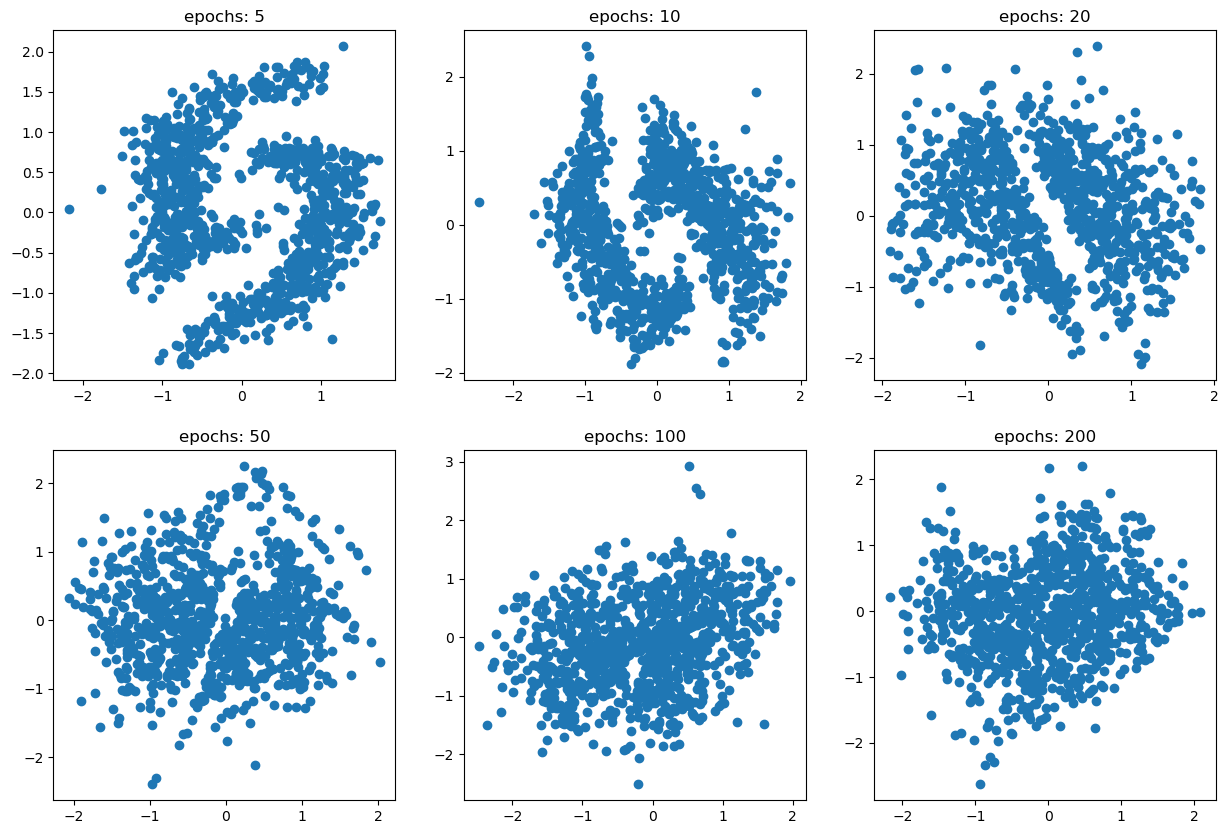

In [27]:
# check the effect of varying the number of epochs
n_samples = 1000
n_epochs = [5, 10, 20, 50, 100, 200]
blocks = 8
hidden_size = 64

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, epoch in enumerate(n_epochs):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with {epoch} epochs')
    train_inn(inn, X, batch_size=batch_size, epochs=epoch)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('epochs: {}'.format(epoch))

Training with batch size 10
Training with batch size 50
Training with batch size 100
Training with batch size 150
Training with batch size 200
Training with batch size 500


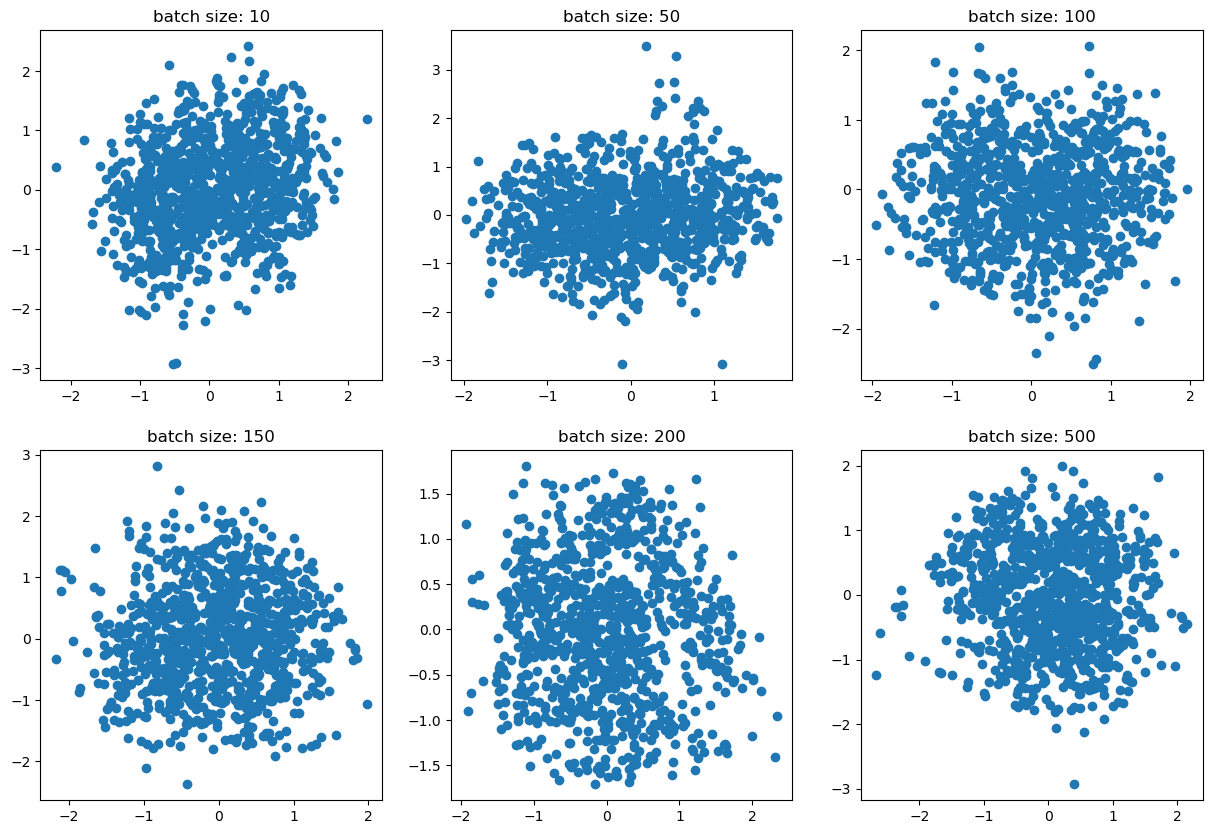

In [28]:
# check the effect of varying the batch size
n_samples = 1000
n_epochs = 100
blocks = 8
hidden_size = 64
batch_sizes = [10, 50, 100, 150, 200, 500]

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, batch_size in enumerate(batch_sizes):
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with batch size {batch_size}')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('batch size: {}'.format(batch_size))

Training with 100 samples
Training with 500 samples
Training with 1000 samples
Training with 2000 samples
Training with 5000 samples
Training with 10000 samples


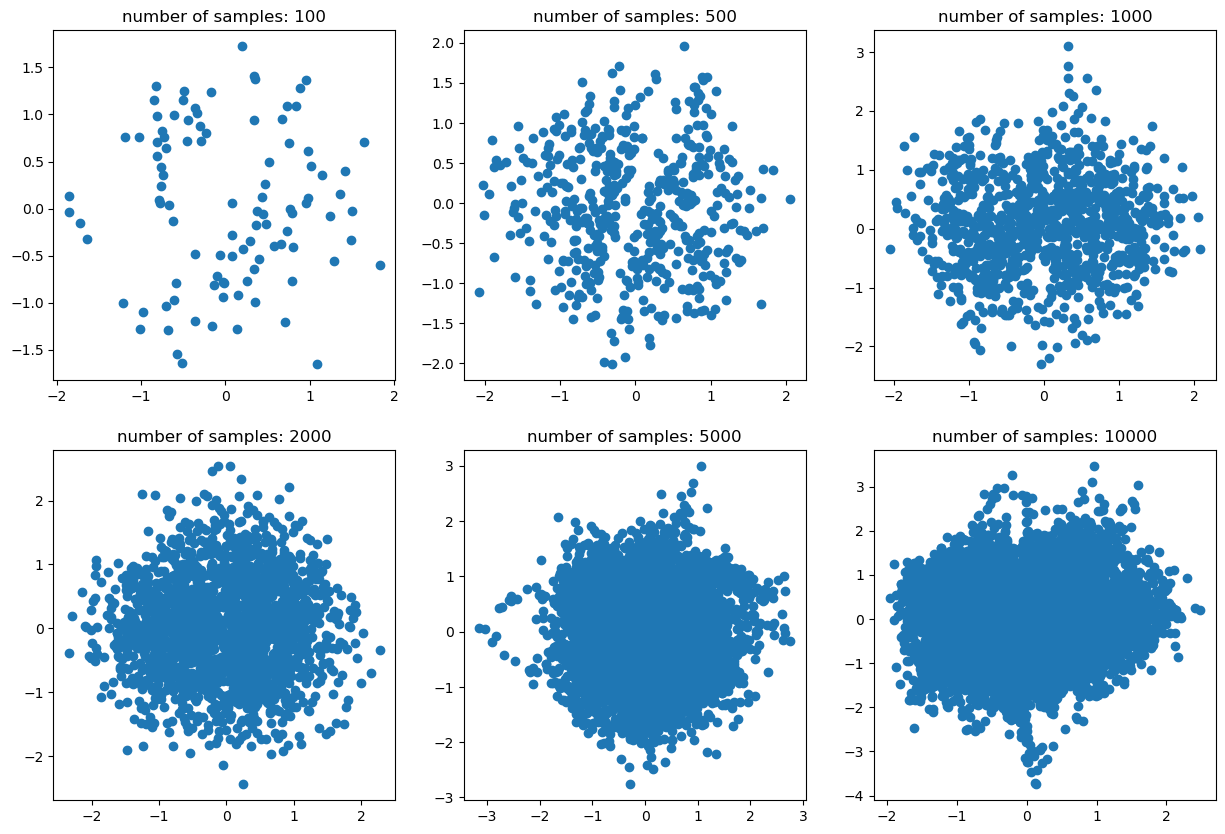

In [29]:
# check the effect of varying the number of samples
n_samples = [100, 500, 1000, 2000, 5000, 10000]
n_epochs = 100
blocks = 8
hidden_size = 64
batch_size = 150

# create a 2*3 grid of plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, n_sample in enumerate(n_samples):
    X, _ = make_moons(n_samples=n_sample, noise=.1)
    X = torch.from_numpy(X).float()
    inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
    print(f'Training with {n_sample} samples')
    train_inn(inn, X, batch_size=batch_size, epochs=n_epochs)
    z, _ = inn(X)
    z = z.detach().numpy()
    axs[i].scatter(z[:, 0], z[:, 1])
    axs[i].set_title('number of samples: {}'.format(n_sample))

Comment: We found that number of samples = 2000, epoch_size = 150, hidden_size = 64, blocks = 8, epoch = 100 could generate code distribution most like standard normal.

In [39]:
# implement the MMD metric with squared exponential kernel and inverse multiquadric kernel
def squared_exponential_kernel(x, y, h = 1):
    return np.exp(-np.linalg.norm(x-y)**2/(2*h))

def inverse_multiquadric_kernel(x, y, h = 1):
    return 1/np.sqrt(np.linalg.norm(x-y)**2 / h + 1)

def MMD2(X, Y, kernel_type, h):
    # X, Y: numpy array
    # return: scalar
    n = len(X)
    m = len(Y)
    if kernel_type == 'squared_exponential':
        kernel = squared_exponential_kernel
    elif kernel_type == 'inverse_multiquadric':
        kernel = inverse_multiquadric_kernel
    else:
        raise ValueError('kernel_type must be squared_exponential or inverse_multiquadric')
    K_XX = np.array([[kernel(X[i], X[j], h) for j in range(n) if j != i] for i in range(n)])
    K_XY = np.array([[kernel(X[i], Y[j], h) for j in range(m)] for i in range(n)])
    K_YY = np.array([[kernel(Y[i], Y[j], h) for j in range(m) if j != i] for i in range(m)])
    return 1/(n*(n-1)) * np.sum(K_XX) - 2/(n*m) * np.sum(K_XY) + 1/(m*(m-1)) * np.sum(K_YY)


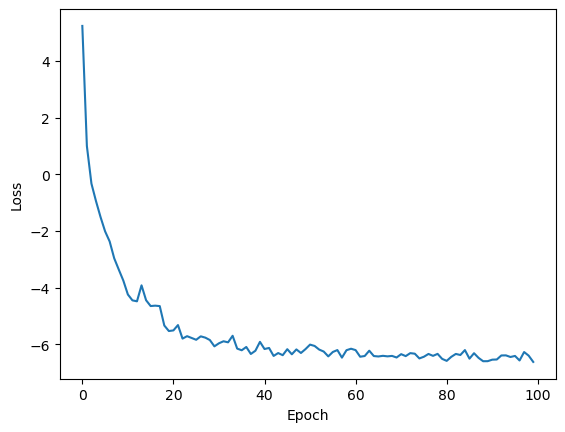

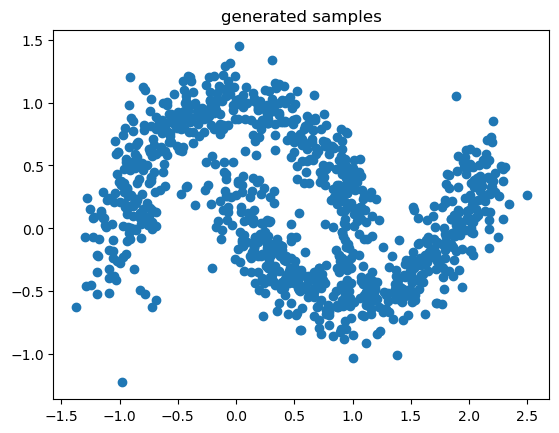

The MMD distance between the generated samples and the original data is 0.003374505785149251


In [40]:
# optimal parameters
n_samples = 2000
n_epochs = 100
blocks = 8
hidden_size = 64
batch_sizes = 150

# train the model
X, _ = make_moons(n_samples=n_samples, noise=.1)
X = torch.from_numpy(X).float()
inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=True)

# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
z_inv = inn.inverse(z)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
plt.scatter(z_inv[:, 0], z_inv[:, 1])
plt.title('generated samples')
plt.show()

# compute the MMD between the generated samples and the original data
MMD_dist = MMD2(z_inv, X.detach().numpy(), kernel_type='squared_exponential', h=1)
print(f'The MMD distance between the generated samples and the original data is {MMD_dist}')

In [ ]:
# show that the smaller MMD means better visualization result


(6, 2)


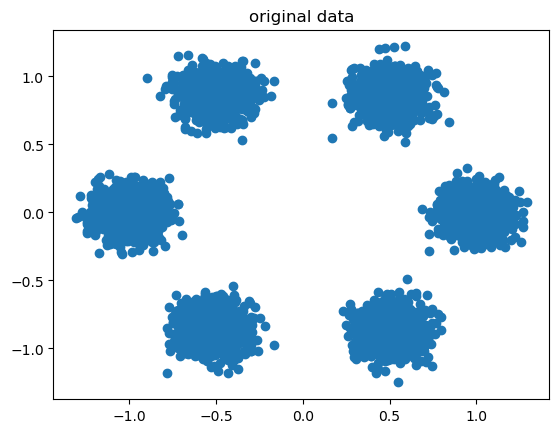

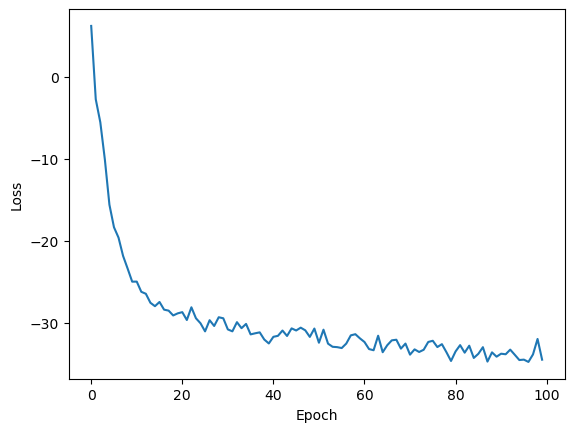

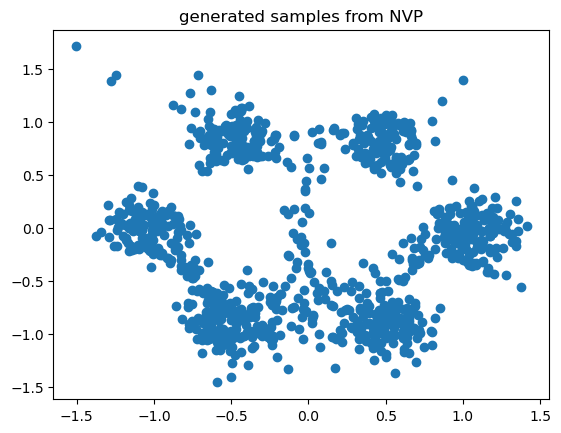

In [45]:
# create a new dataset with Gaussian mixture setting
# create a hexagon and vertices as the center of the Gaussian mixture components
mu = np.array([(math.cos(2*math.pi/6*i), math.sin(2*math.pi/6*i)) for i in range(6)])
# create a dataset with 10000 samples with standard deviation 1/10
sigma = 0.1

print(mu.shape)
# create a Gaussian mixture model dataset
X = np.array([np.random.normal(mu[i], sigma) for i in range(6) for _ in range(1000)])

# visualize the dataset
plt.scatter(X[:, 0], X[:, 1])
plt.title('original data')
plt.show()

# train the model
X = torch.from_numpy(X).float()
inn = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
train_inn(inn, X, batch_size=batch_size, epochs=n_epochs, visualize=True)

# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
z_inv = inn.inverse(z)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
plt.scatter(z_inv[:, 0], z_inv[:, 1])
plt.title('generated samples from NVP')
plt.show()

Comment: Yes, the generated samples from RealNVP are trying to connect the isolated parts of different Gaussian components.

## 2. Two moons with a conditional invertible neural network

In [47]:
# extend the RealNVP to a conditional RealNVP
class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, condition_size):
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks # number of coupling layers
        self.condition_size = condition_size

        self.D_tilde = self.input_size // 2 # dimension of the first half of the input
        # construct the network: two hidden layers with relu activation and one output layer
        self.nets = nn.ModuleList(nn.Sequential(
            nn.Linear(self.D_tilde + self.condition_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.D_tilde * 2) # output layer s and t
        ) for _ in range(self.blocks) )
        
        # construct the orthogonal matrix
        self.shuffle = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        self.shuffle_inverse = nn.ModuleList(nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks-1))
        # initialize the orthogonal matrix using a random orthogonal matrix
        for i in range(self.blocks-1):
            # generate a random orthogonal matrix
            Q, _ = torch.linalg.qr(torch.randn(self.input_size, self.input_size))
            # set the parameters of the linear layer to the random orthogonal matrix
            self.shuffle[i].weight.data = Q
            self.shuffle[i].bias.data = torch.zeros(self.input_size)
            self.shuffle_inverse[i].weight.data = Q.t()
            self.shuffle_inverse[i].bias.data = torch.zeros(self.input_size)
        # freeze the orthogonal matrix
        for param in self.shuffle.parameters():
            param.requires_grad = False
        for param in self.shuffle_inverse.parameters():
            param.requires_grad = False
            
    def forward(self, x, y):
        # for the second half of the dimensions rely on the first half
        log_det_J = 0
        for i in range(self.blocks):
            # the first half of the dimensions are not changed
            x_1 = x[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[i](torch.cat([x_1, y], dim=1)), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            x_2 = x[:, self.D_tilde:] * torch.exp(torch.tanh(s)) + t
            # combine the first and second half of the dimensions
            x = torch.cat([x_1, x_2], dim=1)
            # update the log determinant of the Jacobian
            log_det_J += torch.sum(torch.log(1 - torch.tanh(s)**2) + torch.tanh(s), dim=1)
            if i != self.blocks-1:
                # change the dimensions by the random orthogonormal matrix
                x = self.shuffle[i](x)
        return x, log_det_J
      
    def inverse(self, z, y):
        # for the second half of the dimensions rely on the first half
        for i in range(self.blocks):
            if i != 0:
                # change the dimensions by the inverse of the random orthogonormal matrix
                z = self.shuffle_inverse[self.blocks-1-i](z)
            # the first half of the dimensions are not changed
            z_1 = z[:, :self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation 
            s, t = torch.chunk(self.nets[self.blocks-1-i](torch.cat([z_1, y], dim=1)), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            z_2 = (z[:, self.D_tilde:] - t) * torch.exp(-torch.tanh(s))
            # combine the first and second half of the dimensions
            z = torch.cat([z_1, z_2], dim=1)
        return z
      
    def sample(self, num_samples, conditions):
        # sample from a standard normal distribution
        z = torch.randn(num_samples, self.input_size)
        # apply the inverse of the flow
        x = self.inverse(z, conditions)
        return x

In [77]:
# function to train the conditional RealNVP
def train_conditional_inn(inn, data, condition, batch_size, epochs, visualize=False):
    optimizer = optim.Adam(inn.parameters(), lr=1e-3)
    dataset = list(zip(data, condition))
    train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        for batch in train_loader:
            X_batch, condition_batch = batch
            X_batch = X_batch.float()
            condition_batch = condition_batch.float()
            optimizer.zero_grad()
            z, log_det_J = inn(X_batch, condition_batch)
            loss = 0.5 * torch.mean(torch.sum(z**2, dim=1)) - torch.mean(log_det_J)
            loss.backward()
            optimizer.step()
            running_loss += loss
        loss_history.append(running_loss.item())
    if visualize:
        plt.plot(loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

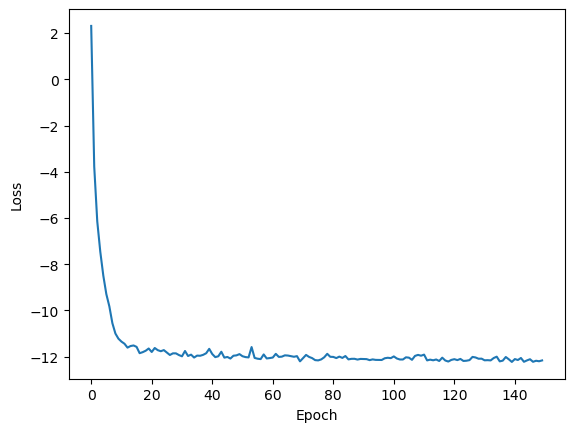

In [81]:
# first use the Moons dataset
n_samples = 2000
n_epochs = 150
blocks = 8
hidden_size = 64
batch_size = 150
input_size = 2
condition_size = 1

X, y = make_moons(n_samples=n_samples, noise=.1)
y = y.reshape(-1, 1)
inn = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_conditional_inn(inn, X, y, batch_size=batch_size, epochs=n_epochs, visualize=True)

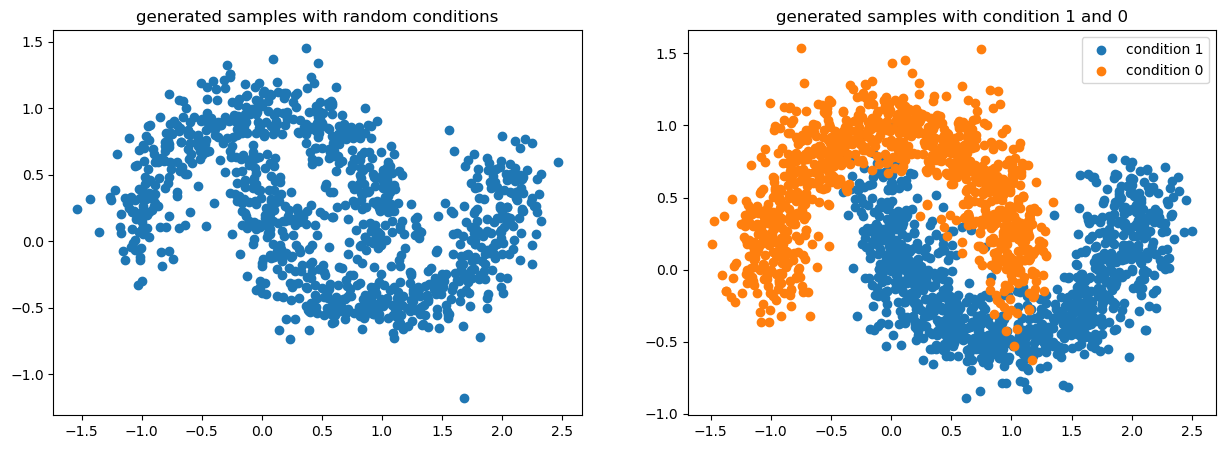

In [82]:
# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
conditions = torch.from_numpy(np.random.randint(0, 2, num_samples)).float().view(-1, 1)
conditions_1 = torch.ones(num_samples, 1).float().view(-1, 1)
conditions_0 = torch.zeros(num_samples, 1).float().view(-1, 1)
z_inv = inn.sample(num_samples, conditions)
z_inv_1 = inn.sample(num_samples, conditions_1)
z_inv_0 = inn.sample(num_samples, conditions_0)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
z_inv_1 = z_inv_1.detach().numpy()
z_inv_0 = z_inv_0.detach().numpy()

# plot two figures: one with random conditions and one with condition 1 and 0 in different colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(z_inv[:, 0], z_inv[:, 1])
axs[0].set_title('generated samples with random conditions')
axs[1].scatter(z_inv_1[:, 0], z_inv_1[:, 1], label='condition 1')
axs[1].scatter(z_inv_0[:, 0], z_inv_0[:, 1], label='condition 0')
axs[1].set_title('generated samples with condition 1 and 0')
axs[1].legend()
plt.show()



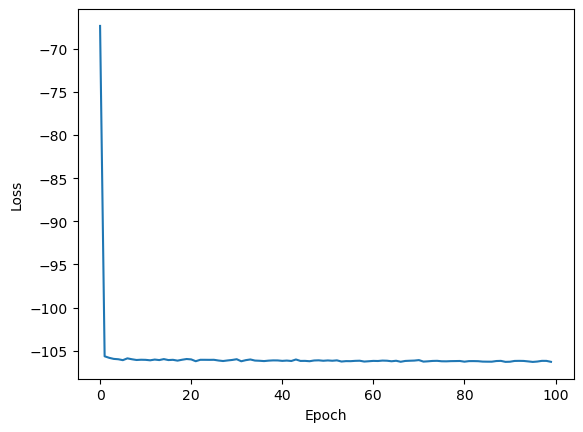

In [87]:
# Create a new dataset with Gaussian mixture setting
num_samples = 10000
# conditions in one-hot encoding; random conditions
conditions_index = np.random.randint(0, 6, num_samples)
conditions = np.eye(6)[conditions_index]
# create a hexagon and vertices as the center of the Gaussian mixture components
mu = np.array([(math.cos(2*math.pi/6*i), math.sin(2*math.pi/6*i)) for i in range(6)])
# create a dataset with 10000 samples with standard deviation 1/10
sigma = 0.1
# create a Gaussian mixture model dataset with conditions
X = np.array([np.random.normal(mu[conditions_index[i]], sigma) for i in range(num_samples)])

# initialize and train the conditional RealNVP
condition_size = 6
input_size = 2
blocks = 8
hidden_size = 64
batch_size = 150
n_epochs = 100

inn = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_conditional_inn(inn, X, conditions, batch_size=batch_size, epochs=n_epochs, visualize=True)

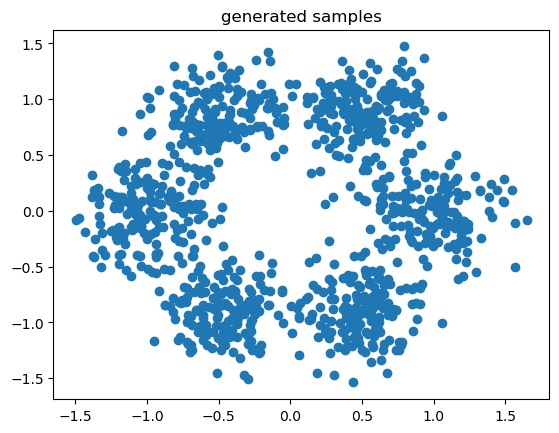

In [88]:
# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
conditions = torch.from_numpy(np.eye(6)[np.random.randint(0, 6, num_samples)]).float()
z_inv = inn.sample(num_samples, conditions)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
plt.scatter(z_inv[:, 0], z_inv[:, 1])
plt.title('generated samples')
plt.show()

(10000, 1)


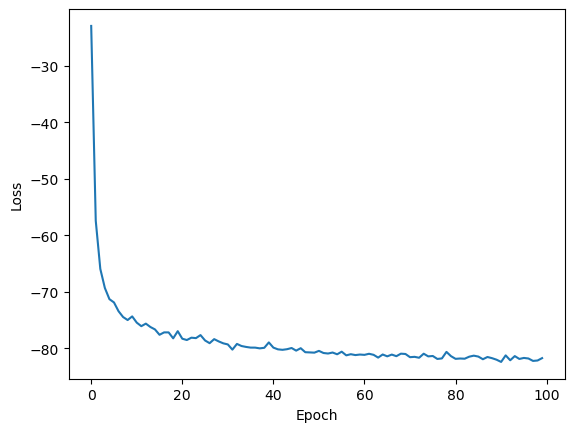

In [93]:
# create a new dataset with Gaussian mixture setting with only 2 conditions
num_samples = 10000
# conditions: two peaks (index = 0 or 3) are 1, the rest are 0
conditions_index = np.random.randint(0, 6, num_samples)
conditions = (conditions_index == 0) | (conditions_index == 3)
conditions = conditions.astype(int).reshape(-1, 1)

# create a hexagon and vertices as the center of the Gaussian mixture components
mu = np.array([(math.cos(2*math.pi/6*i), math.sin(2*math.pi/6*i)) for i in range(6)])
# create a dataset with 10000 samples with standard deviation 1/10
sigma = 0.1
# create a Gaussian mixture model dataset with conditions
X = np.array([np.random.normal(mu[conditions_index[i]], sigma) for i in range(num_samples)])

# initialize and train the conditional RealNVP
condition_size = 1
input_size = 2
blocks = 8
hidden_size = 64
batch_size = 150
n_epochs = 100

inn = ConditionalRealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks, condition_size=condition_size)
train_conditional_inn(inn, X, conditions, batch_size=batch_size, epochs=n_epochs, visualize=True)


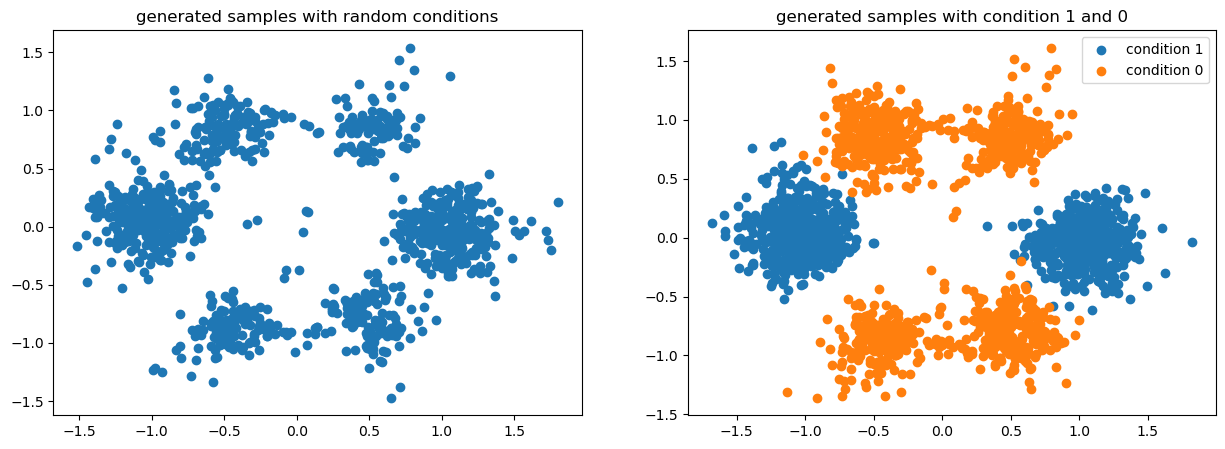

In [94]:
# generate the requested number of samples from a standard normal distribution
num_samples = 1000
z = torch.randn(num_samples, input_size)
conditions = torch.from_numpy(np.random.randint(0, 2, num_samples)).float().view(-1, 1)
conditions_1 = torch.ones(num_samples, 1).float().view(-1, 1)
conditions_0 = torch.zeros(num_samples, 1).float().view(-1, 1)
z_inv = inn.sample(num_samples, conditions)
z_inv_1 = inn.sample(num_samples, conditions_1)
z_inv_0 = inn.sample(num_samples, conditions_0)

# visualize the generated samples
z_inv = z_inv.detach().numpy()
z_inv_1 = z_inv_1.detach().numpy()
z_inv_0 = z_inv_0.detach().numpy()

# plot two figures: one with random conditions and one with condition 1 and 0 in different colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(z_inv[:, 0], z_inv[:, 1])
axs[0].set_title('generated samples with random conditions')
axs[1].scatter(z_inv_1[:, 0], z_inv_1[:, 1], label='condition 1')
axs[1].scatter(z_inv_0[:, 0], z_inv_0[:, 1], label='condition 0')
axs[1].set_title('generated samples with condition 1 and 0')
axs[1].legend()
plt.show()